In [1]:
import sys
sys.path.append("..\..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import trange
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import auc, roc_curve
from src.data.utils.levenshtein import calculate_levenshtein_distances

from src.data.datasets.overlaps import OverlapsDataset
from src.nn.inference.OverlapsNet import OverlapsNetInference
from src.data.loaders.overlaps import get_overlaps_dataloader

In [2]:
dataset = OverlapsDataset.from_path("..\\..\\datasets\\PlagiNet")

df = pd.DataFrame(
    np.concatenate([dataset.features, dataset.targets.reshape(-1, 1)], axis=1), 
    columns=dataset.feature_names + ['is_overlapping']
)
df

Extracting non-overlapping features: 100%|██████████| 2046/2046 [00:52<00:00, 38.72it/s]


,levenshtein_distance,match_len1,match_len2,match_ratio1,match_ratio2,note_C,note_C♯,note_D,note_D♯,note_E,...,interval_6,interval_7,interval_8,interval_9,interval_10,interval_lt,interval_gt,interval_to_rest,interval_from_rest,is_overlapping
0,-0.160440,-0.290194,-0.287466,-0.288709,-0.272194,-0.588623,-0.686576,-0.325411,-0.658348,-0.876159,...,-0.269407,0.054132,-0.339295,-0.402545,-0.313377,-0.532676,-0.359366,-0.942306,-0.942306,1.0
1,-1.587198,3.874273,5.260325,3.892242,2.887591,-0.940983,0.383947,-0.489617,-0.658348,-0.416129,...,-0.269407,1.016486,-0.339295,-0.402545,-0.313377,-0.532676,-0.359366,-0.376814,-0.376814,1.0
2,-1.582702,4.854147,2.671356,4.391805,5.573408,-0.236262,-0.285130,-0.982234,-0.071310,-0.531136,...,0.549842,-0.427044,2.471146,-0.402545,-0.313377,-0.532676,-0.359366,-1.225052,-1.225052,1.0
3,0.962949,-0.290194,-0.287466,-0.288709,-0.272194,2.817529,-0.151314,-0.161206,0.515728,-0.876159,...,-0.269407,-0.908221,-0.339295,-0.402545,-0.313377,2.029095,-0.359366,0.754171,0.754171,1.0
4,1.231586,-0.290194,-0.287466,-0.288709,-0.272194,1.408087,-0.686576,-0.161206,-0.658348,0.848956,...,-0.269407,1.016486,0.285248,4.218279,3.191049,-0.532676,3.060482,-1.225052,-1.225052,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,2.232867,-0.290194,-0.287466,-0.288709,-0.272194,-0.001355,-0.686576,-0.982234,0.124369,-0.646144,...,-0.269407,-0.908221,-0.027023,-0.402545,3.191049,-0.532676,-0.359366,3.581631,3.581631,0.0
2076,0.816420,-0.290194,-0.287466,-0.288709,-0.272194,1.525540,3.194072,-0.489617,1.885482,-0.761152,...,-0.269407,-0.908221,-0.339295,-0.402545,-0.313377,1.388652,0.129184,1.602409,1.602409,0.0
2077,2.232867,-0.290194,-0.287466,-0.288709,-0.272194,0.703366,-0.686576,-0.489617,0.124369,-0.646144,...,-0.269407,0.054132,-0.027023,-0.402545,3.191049,-0.532676,-0.359366,3.581631,3.581631,0.0
2078,0.816420,-0.290194,-0.287466,-0.288709,-0.272194,1.290633,3.194072,-0.325411,1.885482,-0.646144,...,-0.269407,-0.427044,-0.339295,-0.402545,-0.313377,1.388652,0.129184,1.602409,1.602409,0.0


In [16]:
train_dataset = OverlapsDataset.from_path("..\\..\\datasets\\PlagiNet", split="train")
test_dataset = OverlapsDataset.from_path("..\\..\\datasets\\PlagiNet", split="test")

Extracting non-overlapping features: 100%|██████████| 126/126 [00:03<00:00, 33.14it/s]


In [4]:
positive_count = int(np.sum(train_dataset.targets == 1))
negative_count = int(np.sum(train_dataset.targets == 0))

pos_weight = negative_count / positive_count if positive_count > 0 else 1.0
neg_weight = positive_count / negative_count if negative_count > 0 else 1.0

print(f"neg_weight: {neg_weight}")
print(f"pos_weight: {pos_weight}")

neg_weight: 0.02631578947368421
pos_weight: 38.0


In [5]:
X_train = train_dataset.features
X_test = test_dataset.features
y_train = train_dataset.targets
y_test = test_dataset.targets

In [6]:
classifiers = {
    'Логистическая регрессия': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Линейный дискриминантный анализ': LDA(),
    'Метод опорных векторов': svm.SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
    'Дерево решений': DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42),
    'Случайный лес': RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42),
    'Градиентный бустинг': GradientBoostingClassifier(max_depth=6, random_state=42)
}

In [7]:
def calculate_metrics(
    X_test: np.ndarray,
    y_test: np.ndarray,
    classifier: BaseEstimator,
    n_bootstrap: int = 1000,
    confidence_level: float = 0.95,
    seed: int = 42
) -> dict[str, dict[str, list[float]]]:
    """Вычисляет precision, recall и auc с доверительными интервалами на разных порогах с помощью стратифицированного бутстрапа.

    :param np.ndarray X_test: Массив признаков
    :param np.ndarray y_test: Массив целевых значений
    :param BaseEstimator classifier: Классификатор
    :param int n_bootstrap: Количество итераций бутстрапа
    :param float confidence_level: Уровень доверия для интервалов
    :param int seed: Сид для генератора случайных чисел
    :return dict[str, dict[str, list[float]]]: Словарь auc и roc
    """
    rng = np.random.default_rng(seed)
    metrics = {
        "auc": {"mean": None, "lower": None, "upper": None},
        "roc": {"fpr": [], "tpr_mean": [], "tpr_lower": [], "tpr_upper": []}
    }

    fpr_lin = np.linspace(0, 1, 100)
    tpr_boot = []
    aucs = []

    pos_indices = np.where(y_test == 1)[0]
    neg_indices = np.where(y_test == 0)[0]
    
    n_pos = len(pos_indices)
    n_neg = len(neg_indices)
    
    for _ in trange(n_bootstrap, desc="Расчет AUC с доверительными интервалами"):

        boot_pos_indices = rng.choice(pos_indices, size=n_pos, replace=True)
        boot_neg_indices = rng.choice(neg_indices, size=n_neg, replace=True)
        
        boot_indices = np.concatenate([boot_pos_indices, boot_neg_indices])
        
        rng.shuffle(boot_indices)
        
        X_boot = X_test[boot_indices]
        y_boot = y_test[boot_indices]
        
        if len(np.unique(y_boot)) < 2:
            continue
        
        y_pred_proba = classifier.predict_proba(X_boot)[:, 1]
        fpr_i, tpr_i, _ = roc_curve(y_boot, y_pred_proba)
        auc_val = auc(fpr_i, tpr_i)

        aucs.append(auc_val)
        
        interp_tpr = np.interp(fpr_lin, fpr_i, tpr_i)
        interp_tpr[0] = 0.0
        tpr_boot.append(interp_tpr)

    alpha = 1 - confidence_level
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100

    aucs = np.array(aucs)
    metrics["auc"]["mean"] = aucs.mean()
    metrics["auc"]["lower"] = np.percentile(aucs, lower_percentile)
    metrics["auc"]["upper"] = np.percentile(aucs, upper_percentile)

    tpr_boot = np.array(tpr_boot)
    metrics["roc"]["fpr"] = fpr_lin
    metrics["roc"]["tpr_mean"] = tpr_boot.mean(axis=0)
    metrics["roc"]["tpr_lower"] = np.percentile(tpr_boot, lower_percentile, axis=0)
    metrics["roc"]["tpr_upper"] = np.percentile(tpr_boot, upper_percentile, axis=0)

    return metrics

Расчет AUC с доверительными интервалами: 100%|██████████| 1000/1000 [00:00<00:00, 1095.21it/s]


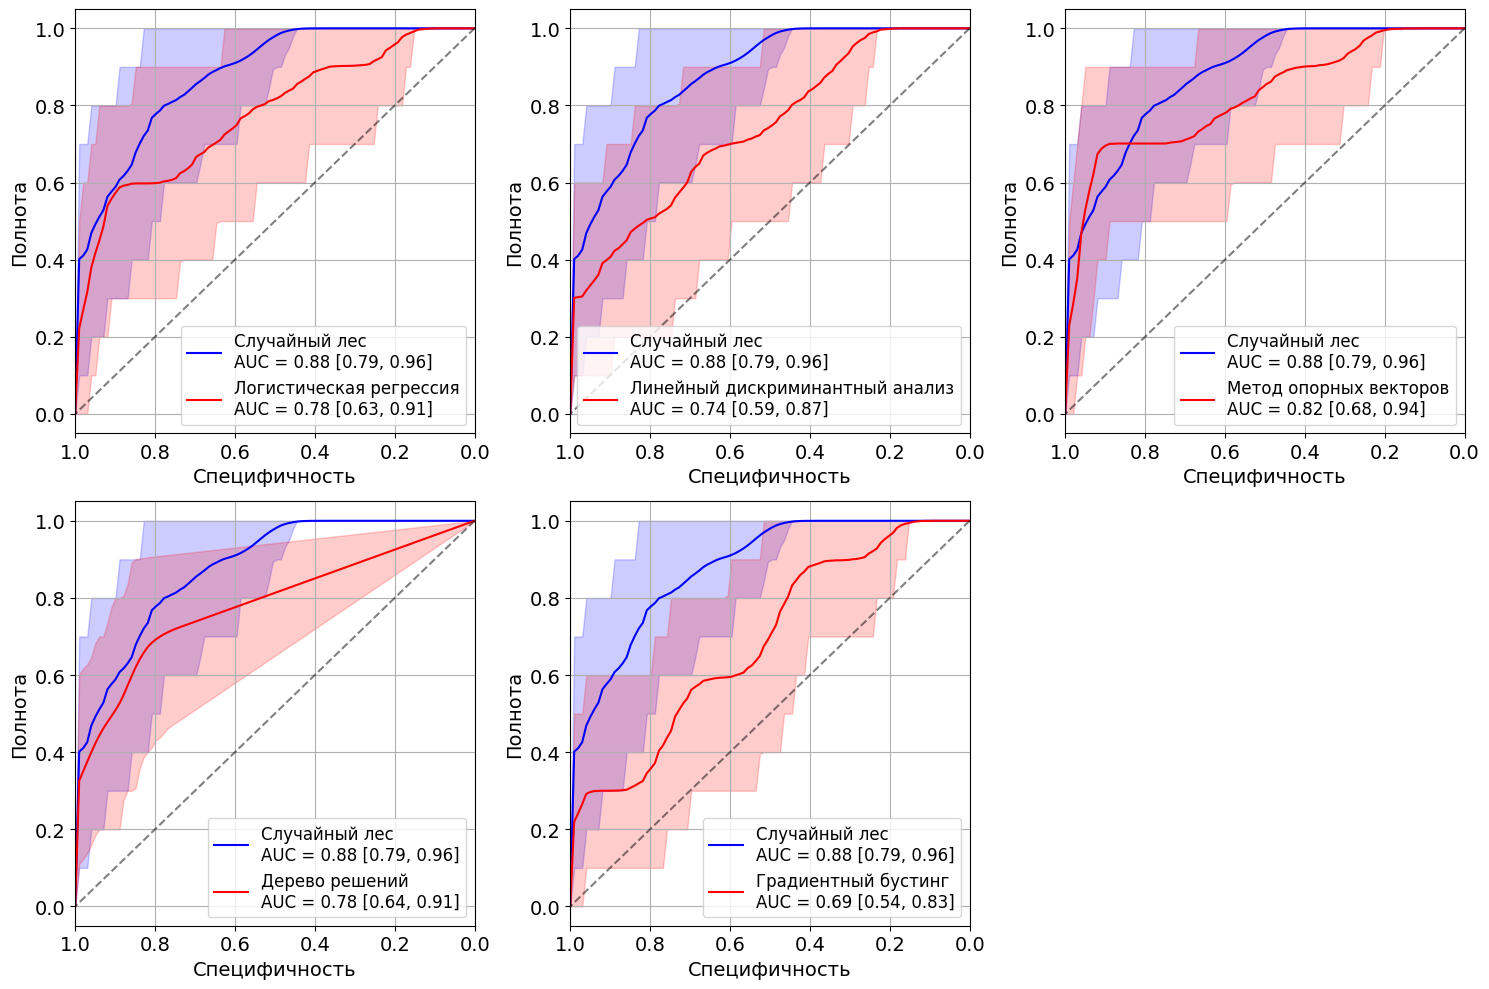

In [8]:
colors = ['blue', 'red']
ci_alpha = 0.2
labels_fontsize=14
legend_fontsize=12
title_fontsize=16
ticks_fontsize=14

rf_classifier = classifiers['Случайный лес']
rf_classifier.fit(X_train, y_train)
rf_metrics = calculate_metrics(X_test, y_test, rf_classifier, confidence_level=0.90)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

plot_idx = 0
for i, (matcher_title, matcher_class) in enumerate(classifiers.items()):

    if matcher_title != 'Случайный лес':
        ax = axes[plot_idx]
        plot_idx += 1
        
        mean_auc = rf_metrics["auc"]["mean"]
        lower_auc = rf_metrics["auc"]["lower"]
        upper_auc = rf_metrics["auc"]["upper"]
        fpr = rf_metrics["roc"]["fpr"]
        tpr_mean = rf_metrics["roc"]["tpr_mean"]
        tpr_lower = rf_metrics["roc"]["tpr_lower"]
        tpr_upper = rf_metrics["roc"]["tpr_upper"]
        
        ax.plot(1-fpr, tpr_mean, label=f"Случайный лес\nAUC = {mean_auc:.2f} [{lower_auc:.2f}, {upper_auc:.2f}]", color=colors[0])
        ax.fill_between(1-fpr, tpr_lower, tpr_upper, alpha=ci_alpha, color=colors[0])
        
        matcher_class.fit(X_train, y_train)
        matcher_metrics = calculate_metrics(X_test, y_test, matcher_class, confidence_level=0.90)
        
        mean_auc = matcher_metrics["auc"]["mean"]
        lower_auc = matcher_metrics["auc"]["lower"]
        upper_auc = matcher_metrics["auc"]["upper"]
        fpr = matcher_metrics["roc"]["fpr"]
        tpr_mean = matcher_metrics["roc"]["tpr_mean"]
        tpr_lower = matcher_metrics["roc"]["tpr_lower"]
        tpr_upper = matcher_metrics["roc"]["tpr_upper"]
        
        ax.plot(1-fpr, tpr_mean, label=f"{matcher_title}\nAUC = {mean_auc:.2f} [{lower_auc:.2f}, {upper_auc:.2f}]", color=colors[1])
        ax.fill_between(1-fpr, tpr_lower, tpr_upper, alpha=ci_alpha, color=colors[1])
        
        ax.plot([0, 1], [1, 0], color="black", linestyle="--", alpha=0.5)
        ax.set_xlabel("Специфичность", fontsize=labels_fontsize)
        ax.set_ylabel("Полнота", fontsize=labels_fontsize)
        ax.set_xlim((1, 0))
        ax.legend(loc="lower right", fontsize=legend_fontsize)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

axes[-1].axis('off')
plt.tight_layout()

In [9]:
rf_classifier = classifiers['Случайный лес']
rf_classifier.fit(X_train, y_train)
rf_metrics = calculate_metrics(X_test, y_test, rf_classifier, confidence_level=0.90)

rf_mean_auc = rf_metrics["auc"]["mean"]
rf_lower_auc = rf_metrics["auc"]["lower"]
rf_upper_auc = rf_metrics["auc"]["upper"]
rf_fpr = rf_metrics["roc"]["fpr"]
rf_tpr_mean = rf_metrics["roc"]["tpr_mean"]
rf_tpr_lower = rf_metrics["roc"]["tpr_lower"]
rf_tpr_upper = rf_metrics["roc"]["tpr_upper"]

Расчет AUC с доверительными интервалами: 100%|██████████| 1000/1000 [00:02<00:00, 392.20it/s]


In [17]:
inference = OverlapsNetInference("../../src/nn/weights/OverlapsNet/best.ckpt")

nn_metrics = inference.bootstrap_inference(
    dataset=test_dataset,
    dataloader_fn=get_overlaps_dataloader,
    confidence_level=0.90
)

nn_mean_auc = nn_metrics["auc"]["mean"]
nn_lower_auc = nn_metrics["auc"]["lower"]
nn_upper_auc = nn_metrics["auc"]["upper"]
nn_fpr = nn_metrics["roc"]["fpr"]
nn_tpr_mean = nn_metrics["roc"]["tpr_mean"]
nn_tpr_lower = nn_metrics["roc"]["tpr_lower"]
nn_tpr_upper = nn_metrics["roc"]["tpr_upper"]

Calculating CI: 100%|██████████| 1000/1000 [00:15<00:00, 64.31it/s]


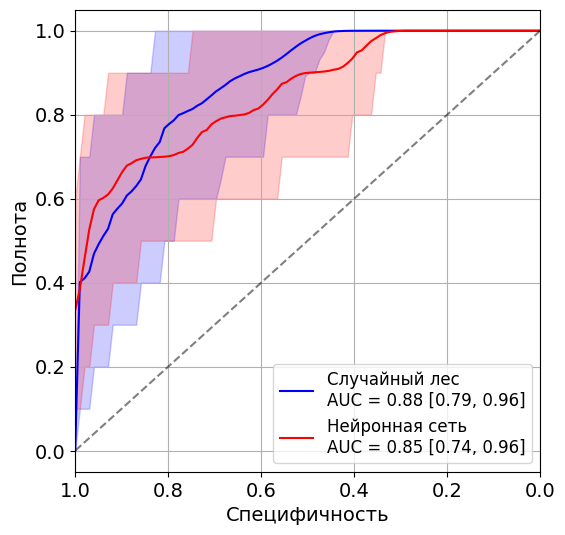

In [15]:
colors = ['blue', 'red']
ci_alpha = 0.2
labels_fontsize=14
legend_fontsize=12
title_fontsize=16
ticks_fontsize=14

fig, ax = plt.subplots(1,1, figsize=(6, 6))

ax.plot(1-rf_fpr, rf_tpr_mean, label=f"Случайный лес\nAUC = {rf_mean_auc:.2f} [{rf_lower_auc:.2f}, {rf_upper_auc:.2f}]", color=colors[0])
ax.fill_between(1-rf_fpr, rf_tpr_lower, rf_tpr_upper, alpha=ci_alpha, color=colors[0])

ax.plot(1-nn_fpr, nn_tpr_mean, label=f"Нейронная сеть\nAUC = {nn_mean_auc:.2f} [{nn_lower_auc:.2f}, {nn_upper_auc:.2f}]", color=colors[1])
ax.fill_between(1-nn_fpr, nn_tpr_lower, nn_tpr_upper, alpha=ci_alpha, color=colors[1])

ax.plot([0, 1], [1, 0], color="black", linestyle="--", alpha=0.5)
ax.set_xlabel("Специфичность", fontsize=labels_fontsize)
ax.set_ylabel("Полнота", fontsize=labels_fontsize)
ax.set_xlim((1, 0))
ax.legend(loc="lower right", fontsize=legend_fontsize)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

Calculating distances: 100%|██████████| 2046/2046 [00:09<00:00, 208.18it/s]


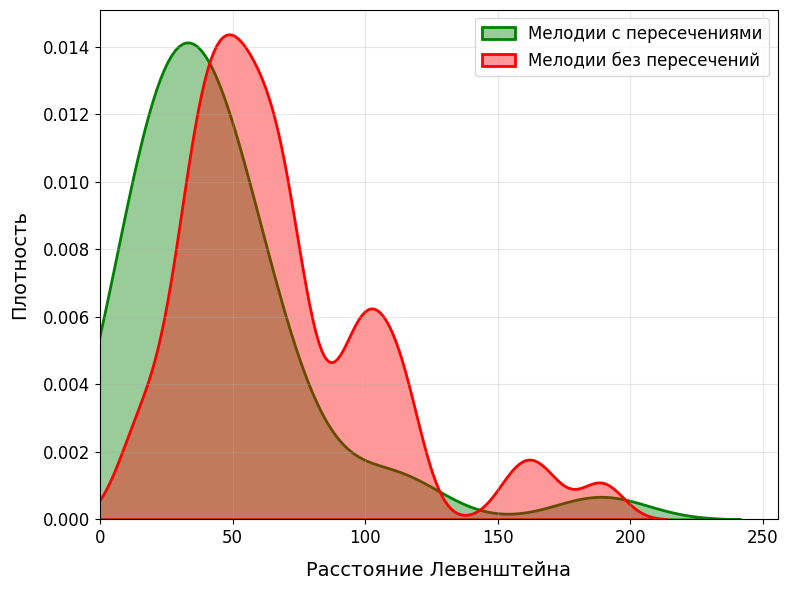

In [12]:
overlapping_distances = calculate_levenshtein_distances(dataset.overlapping_pairs, normalize=False)
non_overlapping_distances = calculate_levenshtein_distances(dataset.non_overlapping_pairs, normalize=False)

all_distances = np.concatenate([overlapping_distances, non_overlapping_distances])
all_labels = np.concatenate([np.ones(len(overlapping_distances)), np.zeros(len(non_overlapping_distances))])

pos_distances = all_distances[all_labels == 1]
neg_distances = all_distances[all_labels == 0]

plt.figure(figsize=(8, 6))

sns.kdeplot(pos_distances, color='green', fill=True, alpha=0.4, label='Мелодии с пересечениями', linewidth=2)
sns.kdeplot(neg_distances, color='red', fill=True, alpha=0.4, label='Мелодии без пересечений', linewidth=2)

plt.xlabel('Расстояние Левенштейна', fontsize=14, labelpad=10)
plt.ylabel('Плотность', fontsize=14, labelpad=10)
plt.xlim(left=0)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()